In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [6]:
data = pd.read_csv('diabetes.csv')
# Nowy plik, bo KNN mocno mieli, więc wolę testować osobno puszczając cały plik

In [47]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [54]:
# Klasa FuzzyClassifier zawierająca klasyfikator zbiorów rozmytych oraz metody pomocnicze
class FuzzyClassifier:
    """
    Normy:
    Pregnancies:
    -
    Glucose:
    - 70-99 prawidlowe
    - 100-125 ryzyko
    - 126+ cukrzyca
    BloodPressure:
    - <80 prawidlowe
    - 80-89 podwyzszone faza 1
    - >90 podwyszone faza 2
    SkinThickness:
    - mediana 25 mm
    Insulin:
    - <30
    Age:
    - ryzyko od 45 r.ż.
    """
    @staticmethod
    def create_rules(df: pd.DataFrame):
        pregnancies = ctrl.Antecedent(df['Pregnancies'].sort_values(), 'pregnancies')
        df['Pregnancies'].value_counts().sort_index().plot.bar(sort_columns=True)
        pregnancies['low'] = fuzz.trimf(pregnancies.universe, [0, 0, 7])
        pregnancies['medium'] = fuzz.trimf(pregnancies.universe, [3, 7, 11])
        pregnancies['high'] = fuzz.trimf(pregnancies.universe, [7, 17, 17])
        pregnancies.view()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


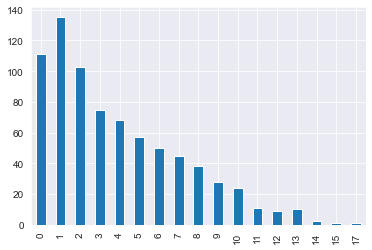

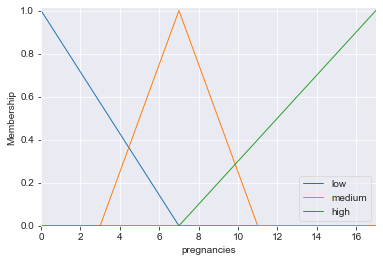

In [55]:
FuzzyClassifier.create_rules(data)